In [13]:
import networkx as nx
import numpy as np
import scipy as sc
from scipy.special import expit # expit is invlogit
from scipy.stats import uniform
from sklearn.linear_model import LinearRegression
from numpy.random import choice


def asymmetry(n_nodes = 400, scale = 3, offset = 0, y_noise = 0.02, friend_noms = 1, 
              response="linear", nominate_by="distance", time_trend=0.3):
    # Generate Node Traits
    node_traits = np.random.uniform(size=n_nodes)
    
    # Calculate Distances b/w traits
    node_traits_i =  np.expand_dims(node_traits,axis=1)
    node_traits_j =  np.expand_dims(node_traits,axis=0)
    distances = np.triu(abs(node_traits_i - node_traits_j))
    
    # Generate Underlying undirected network
    adj_probs = np.triu(np.random.binomial(n=1, p = expit(offset-scale*distances) ,size=(n_nodes,n_nodes)))
    np.fill_diagonal(adj_probs,0)
    
    # Make symmetrical (for undirected purposes)
    idxs_lower = np.tril_indices(n_nodes)
    adj_probs[idxs_lower] = adj_probs.T[idxs_lower]
    
    fixed_distances = distances.copy()
    np.fill_diagonal(fixed_distances, np.inf)
    
    #Calculate Nominated Friendships   
    if nominate_by == "distance":
        mask = (adj_probs == 1)
        possibles = np.where(mask, fixed_distances, np.inf)
        nominees = np.argpartition(possibles, kth=friend_noms, axis=0)[:friend_noms]
    else:
        mask = (adj_probs != 0)
        possibles = np.where(mask, np.expand_dims(expit(-abs(node_traits - 0.5)), axis=0), 0)
        nominees = np.array([choice(n_nodes, size=(friend_noms), p=possibles[i]/sum(possibles[i])) for i in range(n_nodes)]).T
    
    # true adjacency matrix
    aa = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        aa[i, nominees[:,i]] = 1
        
    # fit linear model
    y0 = (node_traits - 0.5) ** 3 + np.random.normal(0,y_noise,node_traits.shape[0])
    y1 = y0 + time_trend * node_traits + np.random.normal(0,y_noise,node_traits.shape[0])
    y2 = y1 + time_trend * node_traits + np.random.normal(0,y_noise,node_traits.shape[0])
    
    infl = aa.dot(y0)
    back = aa.T.dot(y0)
    
    trial = LinearRegression().fit(np.stack([y0, infl, back]).T, y1)
    coefs = np.insert(trial.coef_, 0, trial.intercept_)
    
    XX = np.stack([np.ones(n_nodes), y0, infl, back]).T
    e = abs(y1 - XX.dot(coefs))
    sigma_sq = sum(e)/(len(e)-len(coefs))
    cov_unscaled = np.linalg.inv(np.dot(XX.T, XX))
    
    v_plus_c = np.append(np.diag(cov_unscaled), cov_unscaled[2,3])*sigma_sq
    z_stat = (coefs[2]-coefs[3])/(v_plus_c[2]+v_plus_c[3]+2*v_plus_c[4])
    
#     Returns in order: 
#         Regression Coefficients:  "int.b", "auto.b", "infl.b", "back.b",
#         Variances:                "int.s", "auto.s", "infl.s", "back.s",
#         Covariance:               "cov.infl.back",
#         Z score:                  "z.stat"
    
    return np.concatenate([coefs, v_plus_c, [z_stat]])

asymmetry()

array([ 1.48025512e-01,  2.31881356e+00,  1.29094701e-01,  2.27750686e-01,
        9.95503449e-05,  3.91215839e-02,  3.77839299e-02,  3.57718979e-02,
       -4.36466880e-03, -1.52184678e+00])

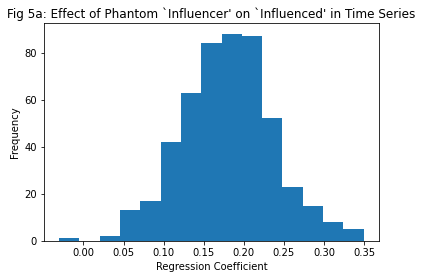

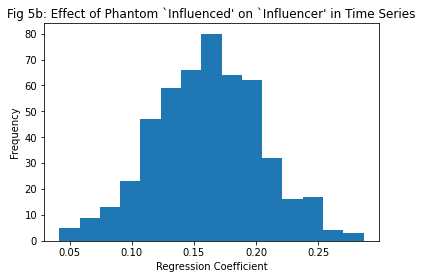

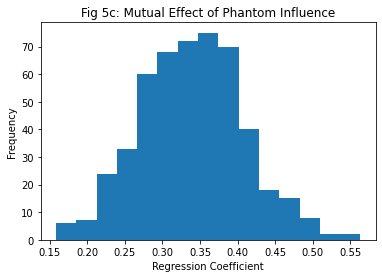

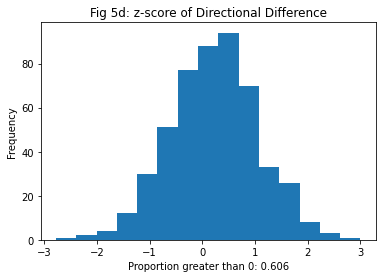

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

result = np.array([asymmetry(n_nodes=400, nominate_by="not-distance") for i in range(500)]).T

plt.hist(result[2], bins=15)
plt.title("Fig 5a: Effect of Phantom `Influencer' on `Influenced' in Time Series")
plt.ylabel('Frequency')
plt.xlabel("Regression Coefficient")
plt.show()


plt.hist(result[3], bins=15)
plt.title("Fig 5b: Effect of Phantom `Influenced' on `Influencer' in Time Series")
plt.ylabel('Frequency')
plt.xlabel("Regression Coefficient")
plt.show()


plt.hist(result[2]+result[3], bins=15)
plt.title("Fig 5c: Mutual Effect of Phantom Influence")
plt.ylabel('Frequency')
plt.xlabel("Regression Coefficient")
plt.show()


plt.hist(result[9], bins=15)
plt.title("Fig 5d: z-score of Directional Difference")
plt.ylabel('Frequency')
plt.xlabel("Proportion greater than 0: {}".format((result[9]>0).mean()))
plt.show()

